In [212]:
%load_ext autoreload
%autoreload 1

import os

import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from statsmodels.nonparametric.smoothers_lowess import lowess


from utils import get_variables, expit_transform, treatment_assigment, get_potential_outcomes
%aimport utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random variables defintions

In [203]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

num_of_experiments = 1000


variables, noise = get_variables(mean_=mean, std_=std, n_=n, m_=amount_of_vars, noise_mean_=noise_mean, noise_std_=noise_std )



# Prop model

## $\pi$ model

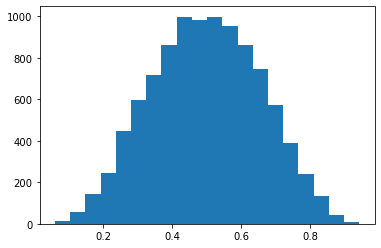

In [208]:
coef = np.array([-0.1, .05, .2, -.05])

exp = expit_transform(coef, variables)
plt.hist(exp, bins=20);

## Treatment assigment

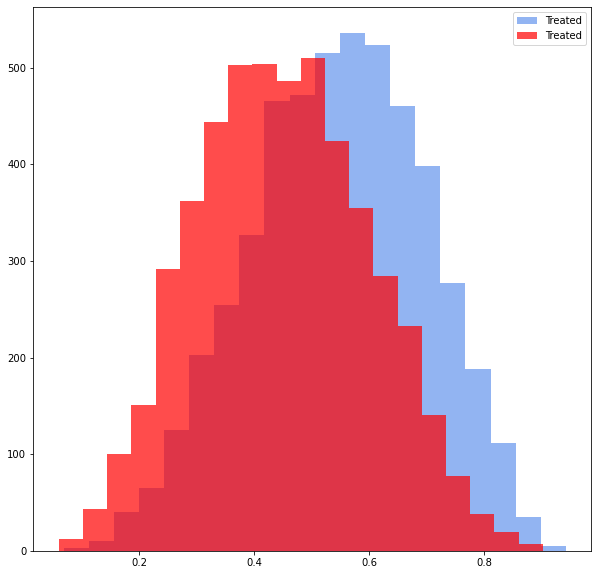

In [210]:



t = treatment_assigment(exp)

fig = plt.figure(figsize=(10, 10))

plt.hist(exp[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
plt.hist(exp[t == 0], bins=20, color='red', alpha=0.7, label= 'Treated');

plt.legend();

# Outcome model

In [236]:
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

potential_outcomes_lst = utils.get_potential_outcomes(variables, y_coef, noise)

y = np.where(t == 1, potential_outcomes_lst[1], potential_outcomes_lst[0])


In [257]:
ate = (potential_outcomes_lst[1]  - potential_outcomes_lst[0]).mean()
ate_hat = utils.calc_ipw(y, t, exp)

In [258]:
ate - ate_hat

-0.2984415867562076

In [259]:
ate_hat / ate

1.0596883173512415

# Calibration Calculation

In [252]:

err_s = pd.Series(err)
brier_score = brier_score_loss(t, exp)
brier = pd.Series(brier_score, index=['brier'])

calib_res_df = err_s.describe(percentiles=[.1, .5, .9]).append(brier).to_frame().T

,count,mean,std,min,10%,50%,90%,max,brier
0,10000.0,0.012729,0.008602,5.416672e-07,0.003705,0.010737,0.026657,0.047116,0.227148


In [260]:
utils.generate_calib_error_df(t, exp).assign(ATE=ate_hat)

,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.012729,0.008602,5.416672e-07,0.003705,0.010737,0.026657,0.047116,0.227148,5.298442


## to check calibration methods

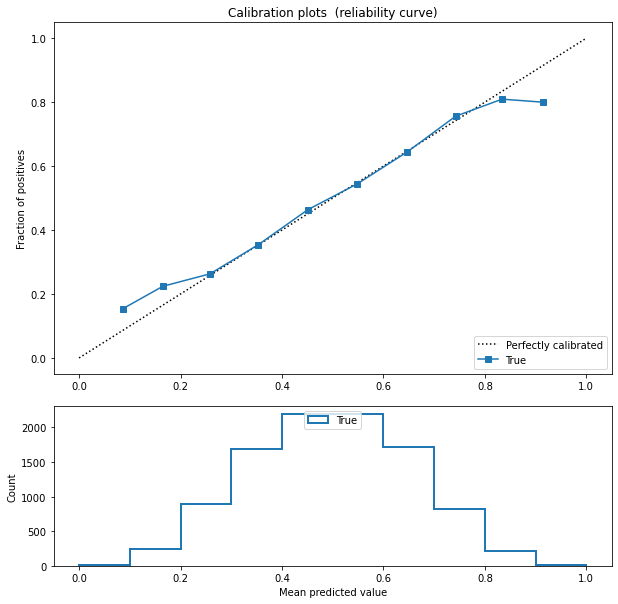

In [254]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


fraction_of_positives, mean_predicted_value = \
    calibration_curve(t, exp, n_bins=10)

name = "True"

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label=f"{name}")

ax2.hist(exp, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

In [193]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

In [197]:
lr = Logit(t, add_constant(exp))

In [198]:
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.638424
         Iterations 5


In [199]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.079      
Dependent Variable: y                AIC:              12772.4852 
Date:               2021-06-16 09:45 BIC:              12786.9059 
No. Observations:   10000            Log-Likelihood:   -6384.2    
Df Model:           1                LL-Null:          -6931.0    
Df Residuals:       9998             LLR p-value:      8.7230e-240
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|    [0.025    0.975] 
-------------------------------------------------------------------
const      -11.6532    0.3776  -30.8646  0.0000  -12.3932  -10.9132
x1          18.7691    0.6060   30.9710  0.0000   17.5813   19.9568
==================================================================

"""

# full simulation

In [274]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

coef = np.array([-0.1, .05, .2, -.05])
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

num_of_experiments = 100

calib_df = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments)


calib_df

100%|██████████| 100/100 [06:17<00:00,  3.78s/it]


,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.019331,0.013200,6.274410e-06,0.005048,0.014893,0.039038,0.075795,0.224056,4.388767
1,10000.0,0.020653,0.011274,4.478792e-07,0.006275,0.019917,0.036185,0.062299,0.224261,4.997267
2,10000.0,0.013910,0.010031,6.647945e-07,0.001129,0.011963,0.027995,0.028362,0.226935,4.717019
3,10000.0,0.007022,0.006109,1.999224e-06,0.002822,0.003908,0.016528,0.036659,0.227879,4.590038
4,10000.0,0.015915,0.008163,6.112302e-06,0.004986,0.013926,0.027259,0.051766,0.227169,4.647127
...,...,...,...,...,...,...,...,...,...,...
95,10000.0,0.020187,0.008888,1.063036e-05,0.006564,0.021886,0.030245,0.048268,0.225301,5.182133
96,10000.0,0.021073,0.014892,6.018501e-07,0.004149,0.019453,0.041253,0.086617,0.222902,5.260816
97,10000.0,0.026513,0.013066,1.552624e-05,0.006379,0.028787,0.042530,0.055371,0.222552,5.301965
98,10000.0,0.018412,0.013736,1.686210e-07,0.001648,0.017348,0.034506,0.077140,0.224442,4.608985
